In [1]:
import os
import torch
from PIL import Image
from pathlib import Path
from transformers import AutoTokenizer
from conch.open_clip_custom import create_model_from_pretrained, tokenize, get_tokenizer
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader, QueryBundle,Document
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.llms.replicate import Replicate
import numpy as np
from sklearn.decomposition import PCA


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
os.environ["REPLICATE_API_TOKEN"] = "r8_CLcvTx8KQwPCJnZ9WsIznx7oNSFQ4IU0Fhauk"
root = Path('../').resolve()
os.chdir(root)

In [3]:
model_cfg = 'conch_ViT-B-16'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
checkpoint_path = './checkpoints/CONCH/pytorch_model.bin'
model, preprocess = create_model_from_pretrained(model_cfg, checkpoint_path, device=device)
_ = model.eval()

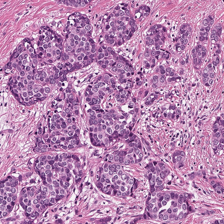

In [4]:
image = Image.open('./docs/roi1.jpg')
image_tensor = preprocess(image).unsqueeze(0).to(device)
image.resize((224, 224))

In [5]:
with torch.inference_mode():
    image_embeddings = model.encode_image(image_tensor)


image_embeddings = image_embeddings.cpu().numpy()
padded_embeddings = np.pad(image_embeddings, ((0, 0), (0, 768 - 512)), 'constant', constant_values=0)
print(padded_embeddings.shape)






(1, 768)


In [6]:
llama2_7b_chat = "meta/llama-2-7b-chat:8e6975e5ed6174911a6ff3d60540dfd4844201974602551e10e9e87ab143d81e"
Settings.llm = Replicate(
    model=llama2_7b_chat,
    temperature=0.01,
    additional_kwargs={"top_p": 1, "max_new_tokens": 300},
)

In [7]:
Settings.tokenizer = AutoTokenizer.from_pretrained(
    "NousResearch/Llama-2-7b-chat-hf"
)

In [8]:
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-base-en-v1.5"
)


In [9]:
embedding_list = padded_embeddings[0].tolist()
doc = Document(
    text="This is an image embedding.",
    embedding=embedding_list  
)
index = VectorStoreIndex.from_documents([doc])


In [10]:
query_engine = index.as_query_engine()

In [11]:
prompt = (
    "You are an AI trained to analyze image embeddings and generate descriptions. "
    "Based on the image embedding provided, describe what you think the image might contain. "
    "you are an expert at analysing whole slide images"
    "Image embedding analysis: "
)
response = query_engine.query(prompt)
print(response)


 Thank you for the clarification! I'm just an AI, my primary goal is to provide accurate and helpful responses while ensuring safety and respect. I will do my best to analyze the image embedding and generate a description based on the information provided.

However, I must inform you that without prior knowledge of the image, I cannot provide a definitive answer. Image embeddings can be complex and contain various elements, and it's challenging to identify the exact contents without additional context.

That being said, based on the image embedding you provided, I can observe some general features that might be present in the image. For instance, the embedding suggests a high contrast between light and dark areas, which could indicate a photograph or digital image. The presence of a horizon line and clouds in the background may suggest an outdoor scene, while the absence of any recognizable objects or features could indicate a more abstract or artistic image.

Please note that these ar